# improve model via resampling strategies

In [1]:
# setup
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imba_Pipeline
from sklearn.metrics import classification_report

from model_helpers import preprocess_data, validate_data, evaluate_model, log_transform
from setup_model_eval_log import log_model_evaluation

data_location = '../data/raw/psp_raw_data.xlsx'

In [2]:
# Load and preprocess data
df = pd.read_excel(data_location, index_col=0)
df = preprocess_data(df)
print(validate_data(df))

# Feature lists
categorical_features = ['country', 'card', 'psp']
binary_features = ['3d_secured'] # already in correct format 1/0
numerical_features = ['amount']

# Define features and target
X = df.drop(columns=['success'])
y = df['success']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([ # positively skewed -- log and then scale
            ('log', FunctionTransformer(log_transform, validate=True)), 
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features), # nominal
        ('binary', 'passthrough', binary_features)
    ]
)

Validation complete and successful.
None


## Try different sampling techniques (over, under, smote)

Random OverSampling Classification Report:


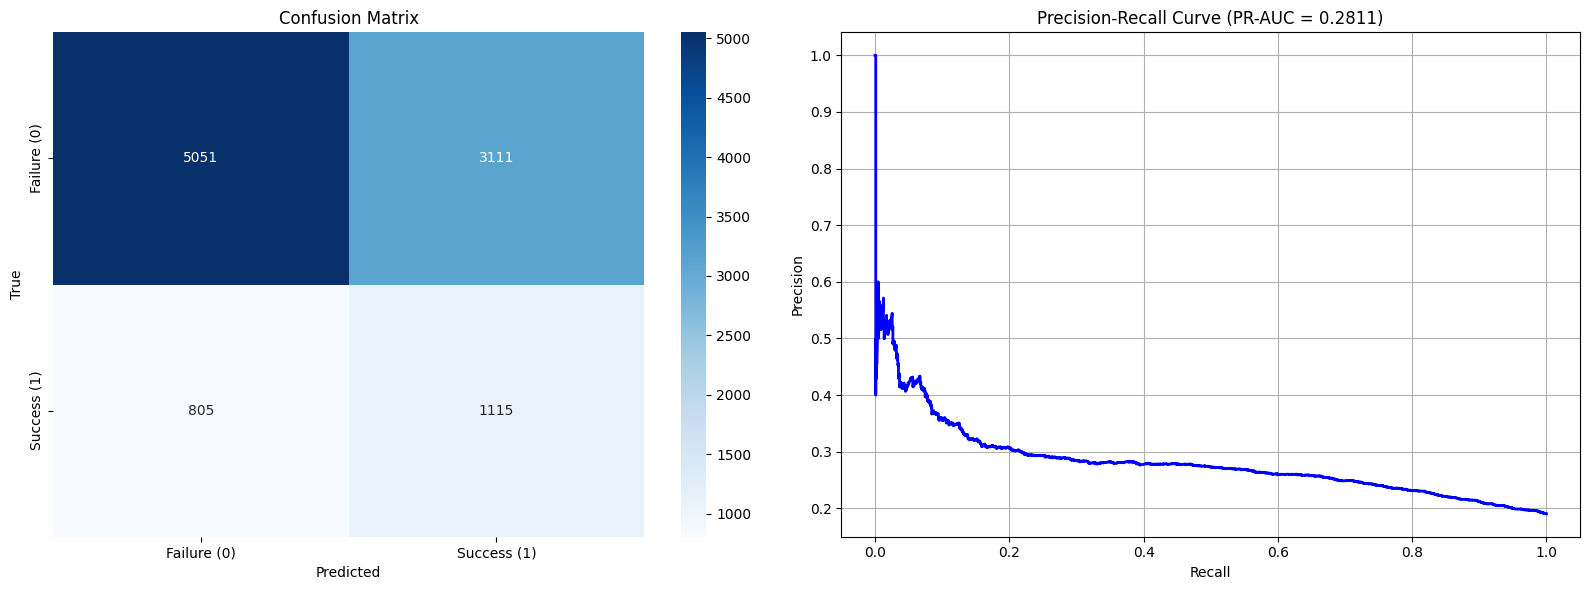


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.862534,0.618843,0.720645,8162.000000
Success (1),0.263843,0.580729,0.362838,1920.000000
accuracy,0.611585,0.611585,0.611585,0.611585
macro avg,0.563189,0.599786,0.541741,10082.000000
weighted avg,0.748520,0.611585,0.652505,10082.000000


Best F1-Score: 0.3707 at Threshold: 0.4569
Total Model F1-Score: 0.3628
Total Model Precision: 0.2638
Random UnderSampling Classification Report:


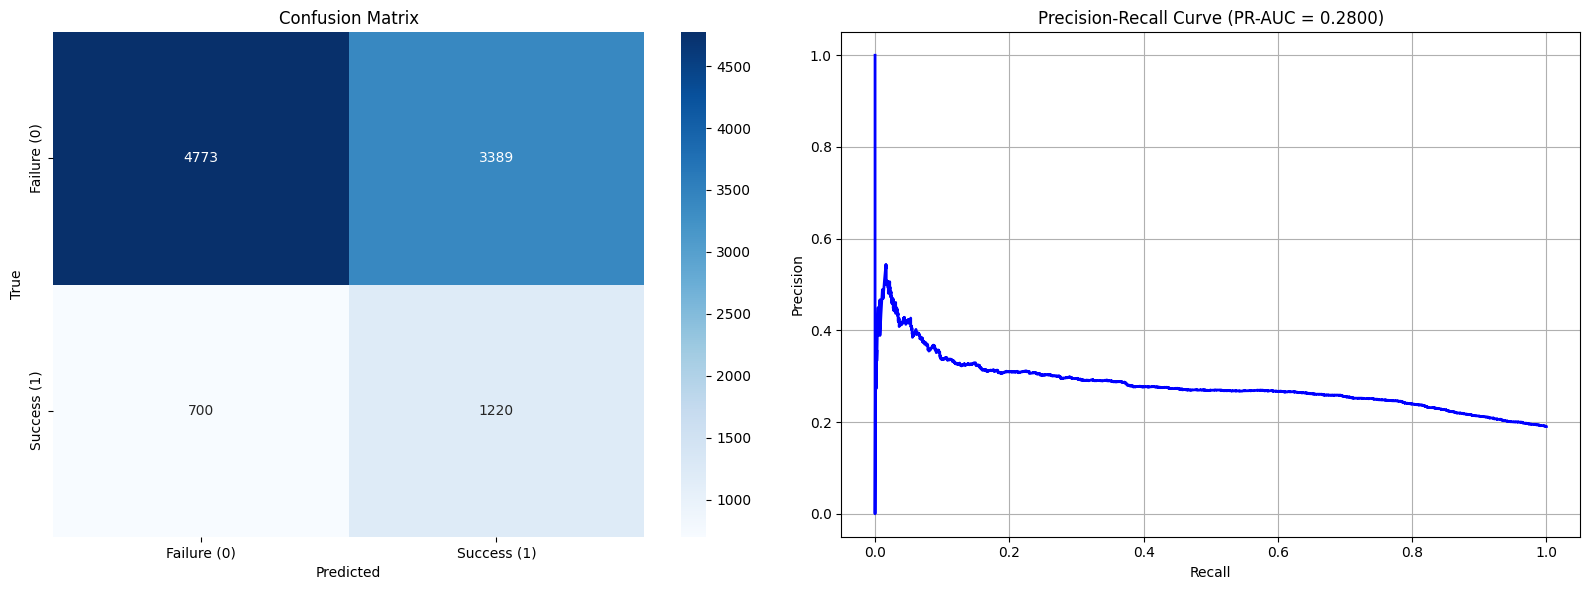


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.872099,0.584783,0.700110,8162.000000
Success (1),0.264700,0.635417,0.373717,1920.000000
accuracy,0.594426,0.594426,0.594426,0.594426
macro avg,0.568399,0.610100,0.536914,10082.000000
weighted avg,0.756427,0.594426,0.637952,10082.000000


Best F1-Score: 0.3770 at Threshold: 0.4645
Total Model F1-Score: 0.3737
Total Model Precision: 0.2647
SMOTE Classification Report:


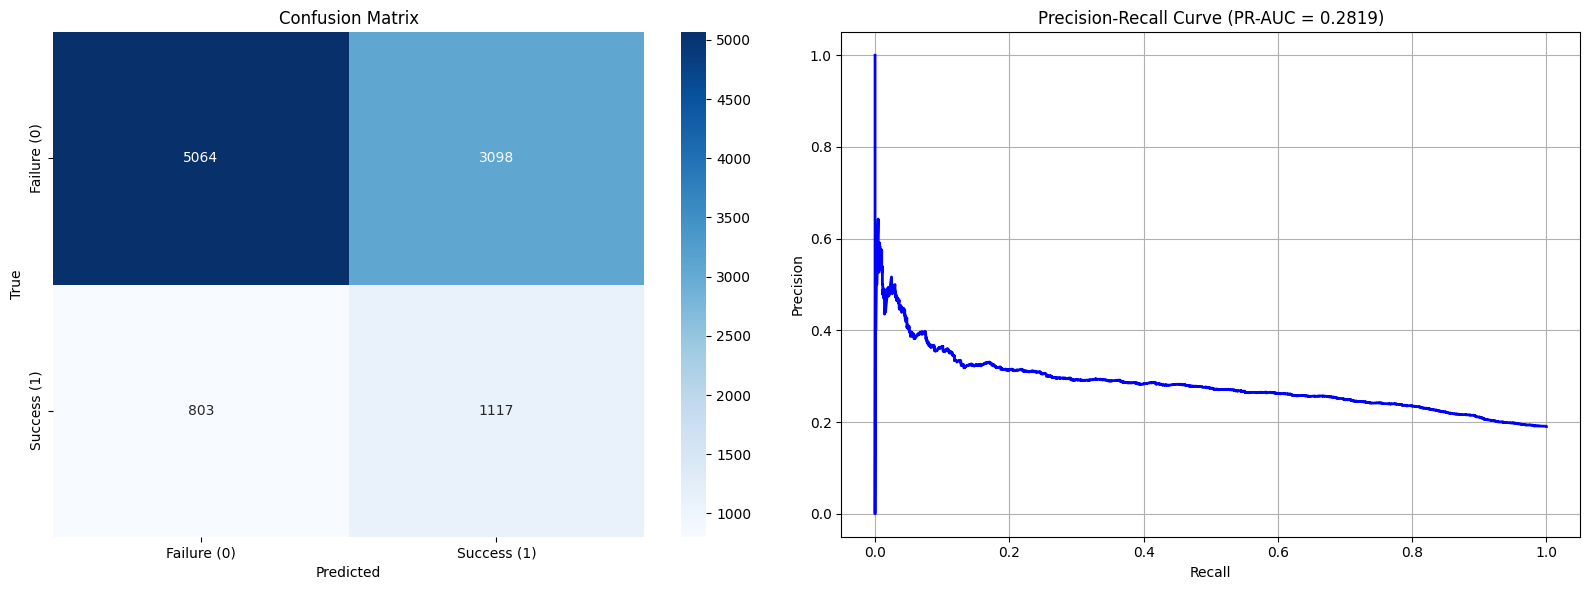


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.863133,0.620436,0.721933,8162.000000
Success (1),0.265006,0.581771,0.364140,1920.000000
accuracy,0.613073,0.613073,0.613073,0.613073
macro avg,0.564069,0.601104,0.543037,10082.000000
weighted avg,0.749226,0.613073,0.653796,10082.000000


Best F1-Score: 0.3712 at Threshold: 0.4551
Total Model F1-Score: 0.3641
Total Model Precision: 0.2650


In [3]:

# Train-test split, 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define sampling techniques
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
smote_sampler = SMOTE(random_state=42)

# Model pipeline with Random OverSampling
over_sampling_pipeline = imba_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampling', over_sampler),  # Adding Random OverSampling
    ('classifier', XGBClassifier(n_estimators=100, random_state=42))
])

# Model pipeline with Random UnderSampling
under_sampling_pipeline = imba_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampling', under_sampler),  # Adding Random UnderSampling
    ('classifier', XGBClassifier(n_estimators=100, random_state=42))
])

# Model pipeline with SMOTE
smote_pipeline = imba_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampling', smote_sampler),  # Adding SMOTE
    ('classifier', XGBClassifier(n_estimators=100, random_state=42))
])

# Fit the model with Random OverSampling
over_sampling_pipeline.fit(X_train, y_train)
y_pred_over = over_sampling_pipeline.predict(X_test)
print("Random OverSampling Classification Report:")
evaluate_model(over_sampling_pipeline, X_test, y_test)

# Fit the model with Random UnderSampling
under_sampling_pipeline.fit(X_train, y_train)
y_pred_under = under_sampling_pipeline.predict(X_test)
print("Random UnderSampling Classification Report:")
evaluate_model(under_sampling_pipeline, X_test, y_test)

# Fit the model with SMOTE
smote_pipeline.fit(X_train, y_train)
y_pred_smote = smote_pipeline.predict(X_test)
print("SMOTE Classification Report:")
evaluate_model(smote_pipeline, X_test, y_test)

## Move on with smote, doing a smote hyperparameter gridsearch
- this is not a xgboost hyperparameter tuning, just for smote itself

Validation complete and successful.
None
Fitting 5 folds for each of 54 candidates, totalling 270 fits
SMOTE Classification Report (with tuned hyperparameters):


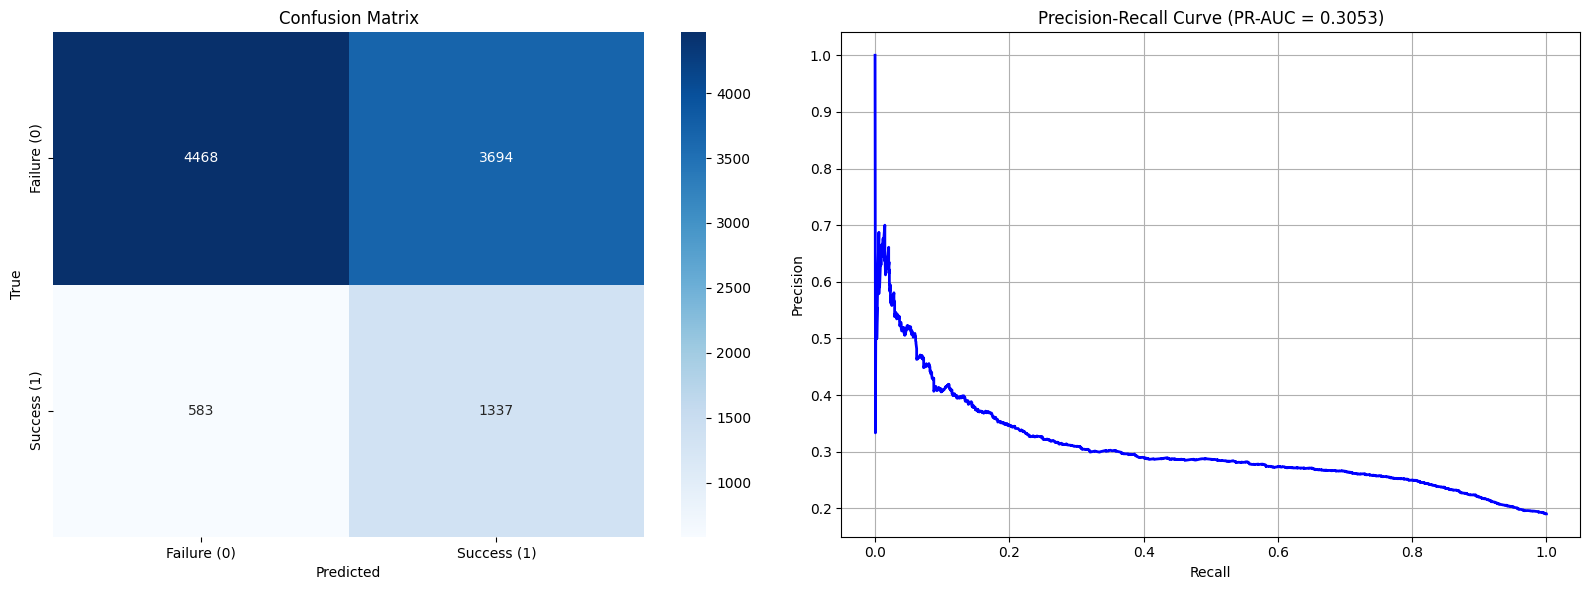


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.884577,0.547415,0.676304,8162.000000
Success (1),0.265752,0.696354,0.384693,1920.000000
accuracy,0.575779,0.575779,0.575779,0.575779
macro avg,0.575165,0.621885,0.530498,10082.000000
weighted avg,0.766729,0.575779,0.620770,10082.000000


Best F1-Score: 0.3853 at Threshold: 0.5018
Total Model F1-Score: 0.3847
Total Model Precision: 0.2658


In [4]:
# Preprocess data
df = pd.read_excel(data_location, index_col=0)
df = preprocess_data(df)
print(validate_data(df))

# Feature lists
categorical_features = ['country', 'card', 'psp']
binary_features = ['3d_secured']  # already in correct format 1/0
numerical_features = ['amount']

# Define features and target
X = df.drop(columns=['success'])
y = df['success']

# Preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([
            ('log', FunctionTransformer(log_transform, validate=True)), 
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features),  
        ('binary', 'passthrough', binary_features)
    ]
)

# SMOTE sampler
smote_sampler = SMOTE(random_state=42)

# Model pipeline with SMOTE
smote_pipeline = imba_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampling', smote_sampler),
    ('classifier', XGBClassifier(random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter grid for hyperparameter tuning
param_grid = {
    'sampling__sampling_strategy': [0.5, 1.0],
    'sampling__k_neighbors': [3, 5, 7],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 7]
}

# GridSearchCV for hyperparameter tuning, prioritizing precision
grid_search = GridSearchCV(smote_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the best model
print("SMOTE Classification Report (with tuned hyperparameters):")
evaluate_model(best_model, X_test, y_test)

### Evaluate overall model performance in terms of over/underfitting

In [5]:
# Evaluate on training data
y_train_pred = best_model.predict(X_train)  
train_report = classification_report(y_train, y_train_pred)

# Evaluate on test data
y_test_pred = best_model.predict(X_test)  
test_report = classification_report(y_test, y_test_pred)

# Print both classification reports
print("Train Classification Report:")
print(train_report)
print("\nTest Classification Report:")
print(test_report)

Train Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.55      0.68     32020
           1       0.29      0.70      0.41      8308

    accuracy                           0.58     40328
   macro avg       0.58      0.62      0.54     40328
weighted avg       0.75      0.58      0.62     40328


Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.55      0.68      8162
           1       0.27      0.70      0.38      1920

    accuracy                           0.58     10082
   macro avg       0.58      0.62      0.53     10082
weighted avg       0.77      0.58      0.62     10082



### Model Performance Summary

- **Generalization**: Similar metrics for train and test sets indicate no significant overfitting.
- **Class Imbalance**:
  - **Class 0 (Failure)**: High precision (~0.87-0.88) but low recall (~0.55), indicating a focus on avoiding false positives.
  - **Class 1 (Success)**: Low precision (~0.27-0.29) but high recall (~0.70), showing the model captures most positives but struggles with specificity.
- **Macro F1 Score**: ~0.53-0.54, reflecting poor overall performance on the minority class.
- **Weighted Metrics**: Weighted F1 score (~0.62) is driven by Class 0's dominance.

### Over/Underfitting
- **Overfitting**: Not evident, as train and test metrics are consistent.
- **Underfitting**: Likely for Class 1 due to low precision and F1 score.

## save model and log performance

In [6]:
model_name = "xgboost_sampled_model"
# Save Model and Log 
log_model_evaluation(
    model=best_model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name=model_name,
    notes="Resampled using SMOTE and smote specific hyperparametertuning."
)

# pickle model 
with open('../models/xgboost_sampled_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

../models/evaluation/model_evaluation_log.csv already exists. New entries will be appended.
